In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [2]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")

## Construct a Target

In [3]:
# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)

df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Contract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [4]:
# Remove rows with more than 7 NaN values
NaN_threshold = 7
df = df[df.isnull().sum(axis=1) <= NaN_threshold]

In [5]:
df1 = df.copy()

In [6]:
# Data Cleaning:

# Finding the mode for "Gender" and "Company size" and using that to fill NaN values in those columns
gender_mode = df1['Gender'].mode()[0] 
df1['Gender'].fillna(gender_mode, inplace=True)

company_mode = df1['Company size'].mode()[0] 
df1['Company size'].fillna(company_mode, inplace=True)

# Replacing low frequency values with "Other"
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

# Using low frequency function on each categorical column, then filling NaN values with "Other"
df1["Seniority level"] = replace_low_freq(df1, "Seniority level", 5, "Other")
df1["Seniority level"].fillna("Other", inplace=True)

df1["City"] = replace_low_freq(df1, "City", 10, "Other")
df1["City"].fillna("Other", inplace=True)

df1["Your main technology / programming language"] = replace_low_freq(df1, "Your main technology / programming language", 10, "Other")
df1["Your main technology / programming language"].fillna("Other", inplace=True)

df1["Other technologies/programming languages you use often"] = replace_low_freq(df1, "Other technologies/programming languages you use often", 10, "Other")
df1["Other technologies/programming languages you use often"].fillna("Other", inplace=True)

df1["Position "] = replace_low_freq(df1, "Position ", 10, "Other")
df1["Position "].fillna("Other", inplace=True)

df1["Company type"] = replace_low_freq(df1, "Company type", 10, "Other")
df1["Company type"].fillna("Other", inplace=True)

df1["Main language at work"] = replace_low_freq(df1, "Main language at work", 10, "Other")
df1["Main language at work"].fillna("Other", inplace=True)

df1["Employment status"] = replace_low_freq(df1, "Employment status", 3, "Other")
df1["Employment status"].fillna("Other", inplace=True)

df1["Contract duration"] = replace_low_freq(df1, "Contract duration", 3, "Other")
df1["Contract duration"].fillna("Other", inplace=True)

In [7]:
# Using an imputer to take the mean of the numerical columns as NaN values
mean_columns = ["Age", "Total years of experience", "Years of experience in Germany", "Number of vacation days"]
imputer = SimpleImputer(strategy='mean')

# Replacing certain symbols in data
replacement = {",":".", "<":" "}
df1['Total years of experience'] = df1['Total years of experience'].replace(replacement, regex=True)
df1['Years of experience in Germany'] = df1['Years of experience in Germany'].replace(replacement, regex=True)

# Converting column values to numerical to remove word values
df1['Total years of experience'] = pd.to_numeric(df1['Total years of experience'], errors='coerce')
df1['Years of experience in Germany'] = pd.to_numeric(df1['Years of experience in Germany'], errors='coerce')
df1['Number of vacation days'] = pd.to_numeric(df1['Number of vacation days'], errors='coerce')

df1[mean_columns] = imputer.fit_transform(df1[mean_columns])

In [8]:
df1.isnull().sum()

Age                                                       0
Gender                                                    0
City                                                      0
Position                                                  0
Total years of experience                                 0
Years of experience in Germany                            0
Seniority level                                           0
Your main technology / programming language               0
Other technologies/programming languages you use often    0
Number of vacation days                                   0
Employment status                                         0
Contract duration                                         0
Main language at work                                     0
Company size                                              0
Company type                                              0
target                                                    0
dtype: int64

In [9]:
# Feature selection using Variance Threshold
df2 = pd.get_dummies(df1, drop_first=True)
y = df2["target"]
X = df2.drop(columns={"target"})

from sklearn.feature_selection import VarianceThreshold
var_th = VarianceThreshold(.2)
print(X.shape)
post_vt = var_th.fit_transform(X)
print(post_vt.shape)

mask = var_th.get_support()
new_features = X.columns[mask]
print(new_features)

(1247, 71)
(1247, 10)
Index(['Age', 'Total years of experience', 'Years of experience in Germany',
       'Number of vacation days', 'Position _Software Engineer',
       'Seniority level_Middle', 'Seniority level_Senior',
       'Your main technology / programming language_Other',
       'Company size_101-1000', 'Company type_Product'],
      dtype='object')


In [10]:
# New data frame after results of variance threshold feature selection
df_fs1 = df1.copy()
df_fs1.drop(columns={"Gender", "Other technologies/programming languages you use often", "Employment status", "Main language at work"}, inplace=True)
df_fs1.head(15)

,Age,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Number of vacation days,Contract duration,Company size,Company type,target
0,26.000000,Munich,Software Engineer,5.000000,3.00000,Senior,TypeScript,30.000000,Unlimited contract,51-100,Product,85000.0
1,26.000000,Berlin,Backend Developer,7.000000,4.00000,Senior,Ruby,28.000000,Unlimited contract,101-1000,Product,80000.0
2,29.000000,Berlin,Software Engineer,12.000000,6.00000,Lead,Other,30.000000,Temporary contract,101-1000,Product,240000.0
3,28.000000,Berlin,Frontend Developer,4.000000,1.00000,Junior,Javascript,24.000000,Unlimited contract,51-100,Startup,54000.0
4,37.000000,Berlin,Backend Developer,17.000000,6.00000,Senior,Other,29.000000,Unlimited contract,101-1000,Product,62000.0
5,32.000000,Berlin,DevOps,5.000000,1.00000,Senior,Other,30.000000,Unlimited contract,11-50,Startup,81000.0
6,37.000000,Berlin,Frontend Developer,6.000000,0.40000,Middle,Javascript,24.000000,Unlimited contract,11-50,Product,57000.0
7,24.000000,Berlin,Frontend Developer,5.000000,1.00000,Senior,Other,27.000000,Unlimited contract,1000+,Product,65000.0
8,29.000000,Berlin,Backend Developer,8.000000,2.00000,Senior,PHP,28.000000,Unlimited contract,101-1000,Product,56000.0
9,35.000000,Berlin,Software Engineer,15.000000,3.00000,Lead,Java,30.000000,Unlimited contract,101-1000,Product,95000.0


In [11]:
# Ordinal encoding for "Seniority level"
seniority_order = {'Other': 0, 'Junior': 1, 'Middle': 2, 'Senior': 3, 'Lead': 4, 'Head': 5}
df1['Seniority level'] = df1['Seniority level'].map(seniority_order)

In [19]:
# One hot encoding for all other categorical columns
df2 = pd.get_dummies(df1, drop_first=True)
y = np.array(df2["target"]).reshape(-1,1)
X = np.array(df2.drop(columns={"target"}))

xTrain,xTest,yTrain,yTest = train_test_split(X,y,test_size=.3)

#Train model with Linear Regression
model = LinearRegression().fit(xTrain,yTrain)
print("Training R2:", model.score(xTrain,yTrain))

#RMSE with test data
model_preds = model.predict(xTest)
print("RMSE test:", mean_squared_error(model_preds,yTest,squared=False))
print("R2 test:", model.score(xTest,yTest))

Training R2: 0.4168224588558743
RMSE test: 446232427.6458258
R2 test: -46258340.75789712


In [13]:
#plt.figure(figsize=(20,5))
#sns.histplot(df['target'])

In [14]:
df_d2 = pd.get_dummies(df_d, drop_first=True)
dfYd = df_d2["BMI"]
dfXd = df_d2.drop(columns={"BMI", "Pregnancies"})

yD = np.array(dfYd).reshape(-1,1)
xD = np.array(dfXd)
xD.shape, yD.shape

#Train model and get R2 from training
dm = LinearRegression().fit(xTrainD,yTrainD)
print("Training R2:", dm.score(xTrainD,yTrainD))

#RMSE with test data
dpreds = dm.predict(xTestD)
print("RMSE test:", mean_squared_error(dpreds,yTestD,squared=False))
print("R2 test:", dm.score(xTestD,yTestD))

for i in df2.columns:
    df2[i] = df2[i].astype('category')
df2.info()

NameError: name 'df_d' is not defined

## We Will Look at The Programming Languages

This column has some messy data. We will try to clean it up a bit. 

### Counts of Values

First, we should see how many different values there are, it looks like quite a few. 

In [ ]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [ ]:
df["Your main technology / programming language"].value_counts()

Java                 184
Python               164
PHP                   56
C++                   38
JavaScript            34
                    ... 
Go, PHP, SQL           1
Kotlin                 1
Jira                   1
Qml                    1
consumer analysis      1
Name: Your main technology / programming language, Length: 256, dtype: int64

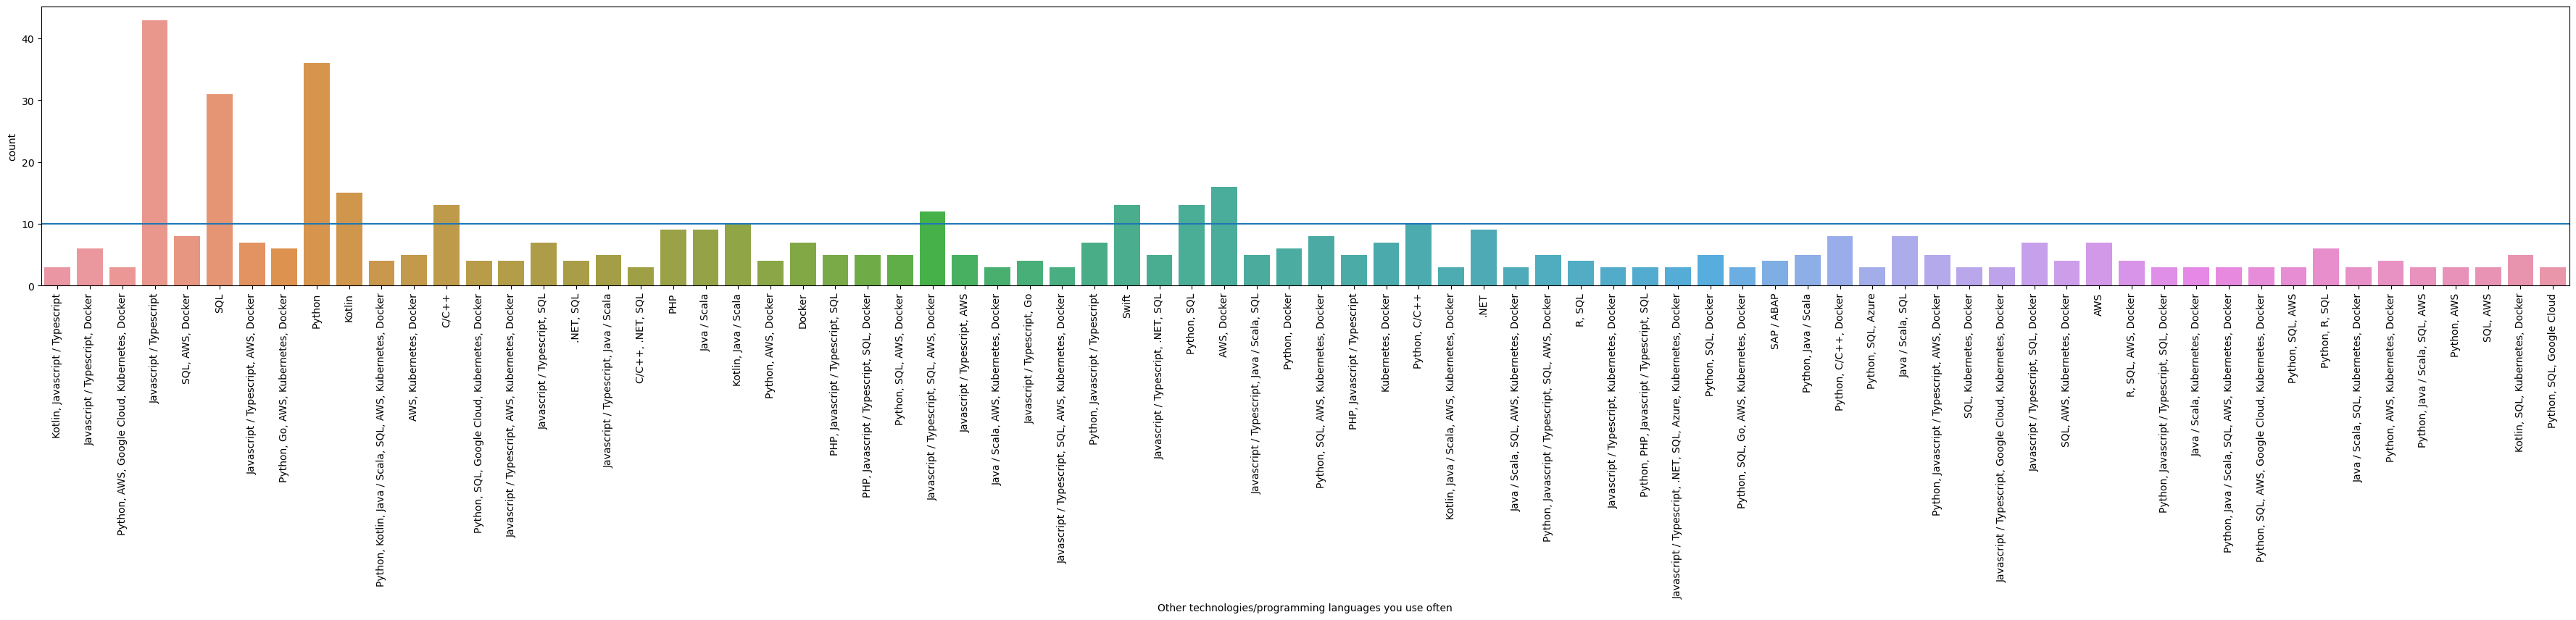

In [ ]:
# Construct a temporary dataset with things that have > 2 records
# remove outliers
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(10)
ax.tick_params(axis='x', rotation=90)

### Look at the Groups vs the Target

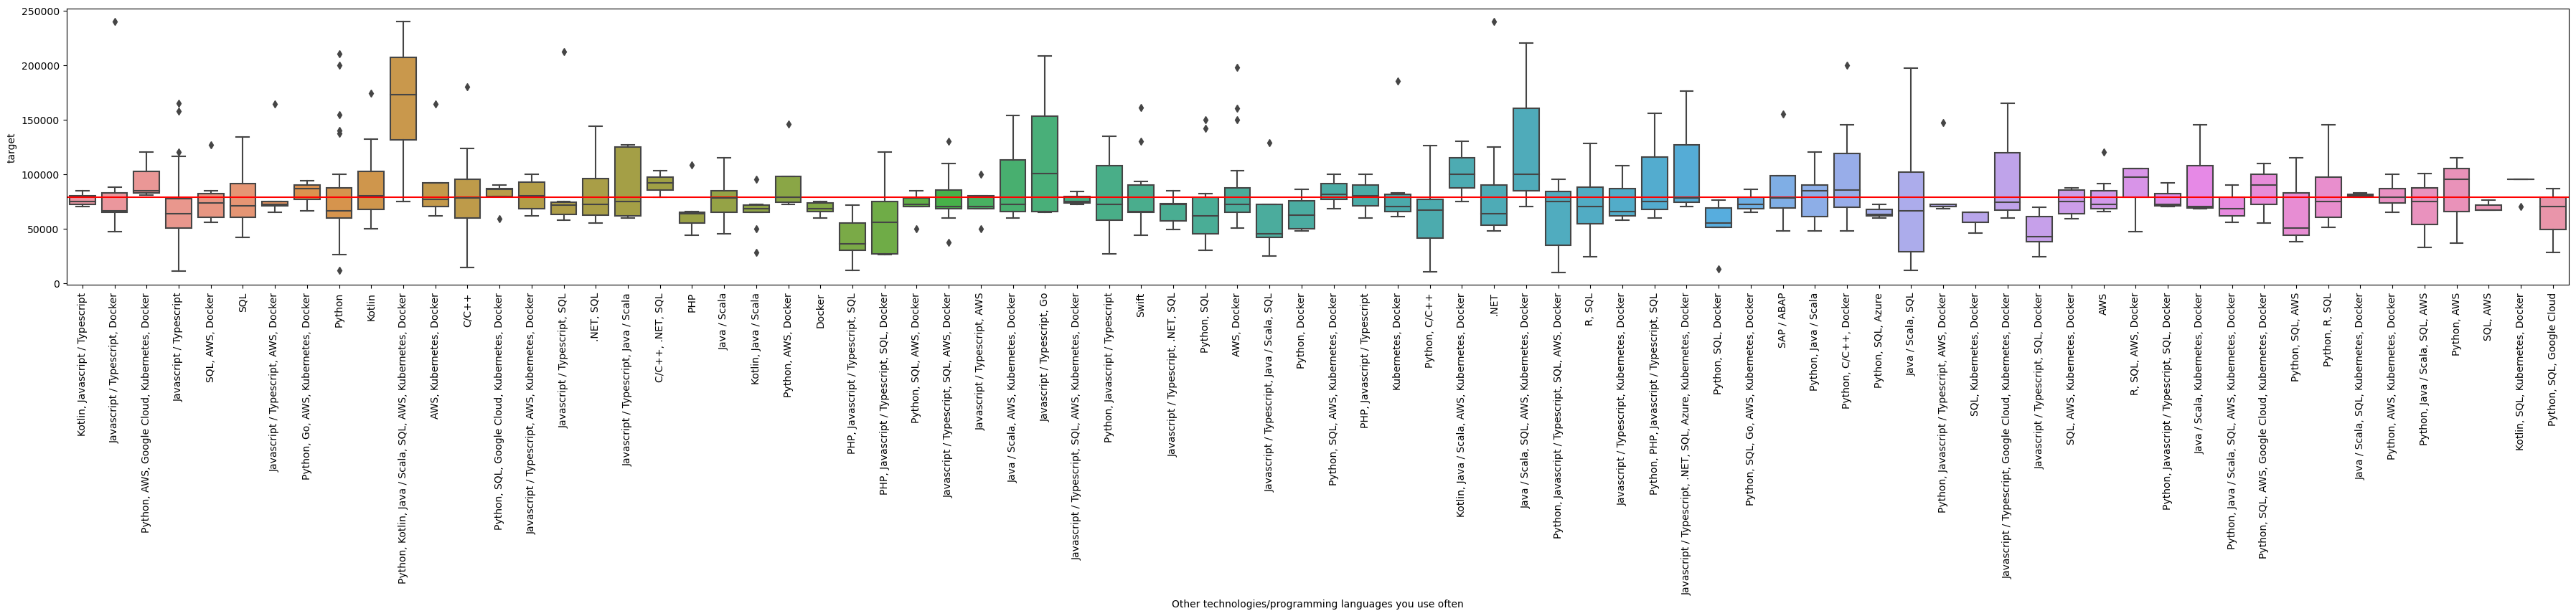

In [ ]:
plt.figure(figsize=(45,5))
ax = sns.boxplot(x="Other technologies/programming languages you use often", y="target", data=df_tmp)
ax.axhline(df_tmp["target"].mean(), color="red")
ax.tick_params(axis='x', rotation=90)

### Conclusions to this Point

We can learn a few things from the exploration we just did:
<ul>
<li> The programming languages have lots of different values, many with few records in them. 
<li> There seems to be quite a bit of overlap and duplication between the values, with many providing a listing of several languages.
<li> The relationship of those groups to the target isn't incredibly clear that there's a strong trend:
    <ul>
    <li> Most of the languages span a <i>similar</i> range. 
    <li> Those that seem to have substantially different salaries don't seem to have that many occurances. Some also seem to be combinations of several languages. 
    <li> The languages that occur pretty frequently seem to have a similar range of salaries. (Pyhton, JS, SQL...)
    </ul>
</ul>

If we mix in a little bit of domain knowledge, this makes some sense - many jobs require a few languages so seeing the odd mixes isn't too surprising, and many/most programmers will shift through several languages during their career. As well, if people were surveyed at one point in time, they probably just responded with the languages they were using at that time, and not necessarily the languages they used most frequently overall, or those most significant to their career.

So what should we do? We have a few options:
<ol>
<li> We could deconstruct each of the values (tokenize), and break the ones with multiple languages into several separate values - similar to a one-hot encoding with a column for each language, and a 1 if that person uses it.
    <ul>
    <li> This would likely keep the most information from the original data. 
    <li> This is somewhat more complex to assemble in the data prep. 
    <li> I'm not confident that this would be worth the effort, but it might be, we'll hold off. 
    <li> I have a (domain knowledge based) suspicion that this may emphasize errors stemming from data collection. If someone was to ask a couple of random data scientists what languages they use, one may answer "python", the other may answer "python, sql, docker, kubernetes, AWS, Google Cloud" and these two people might have the exact same job - doing some machine learning on a cloud platform.
    <li> Tokenization combined with some of the stuff in this link will help if you choose to do it this way, it isn't particularly complex but will involve some manipulation of the data: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
    </ul>
<li> We could drop the column entirely. Based on the initial exploration I kind of suspect that the language isn't a huge factor in the salary, but we'll hold off on that too. We can always drop tings later.  
<li> We could group the less frequent options into an "other" category. This would be a bit of a compromise, but it would be a lot easier to implement than the first option.
</ol>

I'm going to go with option number 3 for now. This isn't a definitive "correct answer", but it is reasonable. Grouping the less frequent values doesn't look like we'll lose too much predictive value, as it appears that there aren't really any strong trends to begin with.

In [ ]:
def replace_low_freq(d, col, threshold=10, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [ ]:
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts()

Other         377
Java          184
Python        164
PHP            56
C++            38
JavaScript     34
Javascript     31
C#             30
python         26
Swift          24
Scala          24
Go             23
Kotlin         22
Python         21
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

Fix a couple of spelling mistakes...

In [ ]:
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python", "python":"Python"}, inplace=True)
df["Your main technology / programming language"].value_counts()

Other         377
Python        211
Java          184
JavaScript     65
PHP            56
C++            38
C#             30
Scala          24
Swift          24
Go             23
Kotlin         22
Ruby           19
TypeScript     14
SQL            14
.NET           13
JS             12
Name: Your main technology / programming language, dtype: int64

### Done!

Looks reasonable. As mentioned, this isn't a definite answer, but it was a pretty reasonable action to take. I have a sneaking suspicion that dropping this column entirely would also be reasonable, but we can always do that later, or it can always be filtered out by some feature selection thing if it ends up being emperically not useful. Use of a second common language will be kept in our data, but we'll lose some accuracy from those who provided a massive list. 

What about breaking the data apart into individual languages, and assembling a one-hot-ish matrix of language use. Honestly, I'd hold something like that off until later, and see how things go. In a vacuum it may be "better", but I'm honestly not sure this column is worth it. 